Using device: cuda
SVM Average Accuracy: 0.9285
Logistic Regression Average Accuracy: 0.9372
SVM Average F1-Score: 0.9268
Logistic Regression Average F1-Score: 0.9360

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      1263
           1       0.88      0.98      0.93      1263
           2       0.99      0.81      0.89      1263

    accuracy                           0.93      3789
   macro avg       0.93      0.93      0.93      3789
weighted avg       0.93      0.93      0.93      3789


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1263
           1       0.90      0.98      0.94      1263
           2       0.98      0.84      0.90      1263

    accuracy                           0.94      3789
   macro avg       0.94      0.94      0.94      3789
weighted avg       0.94      0.94      0.94      378

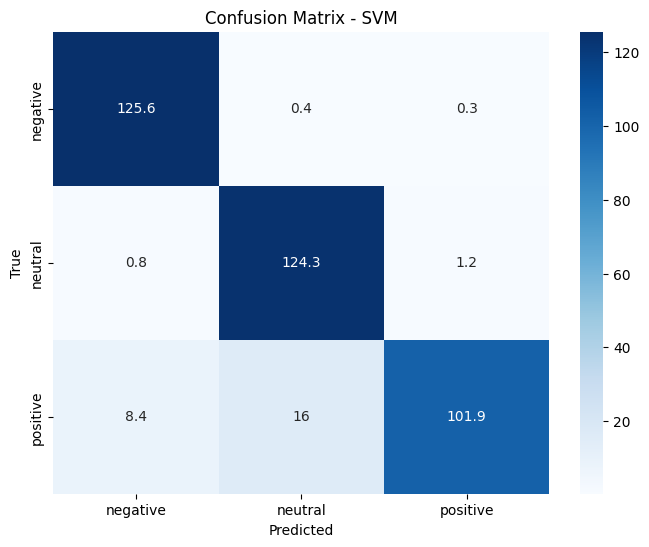

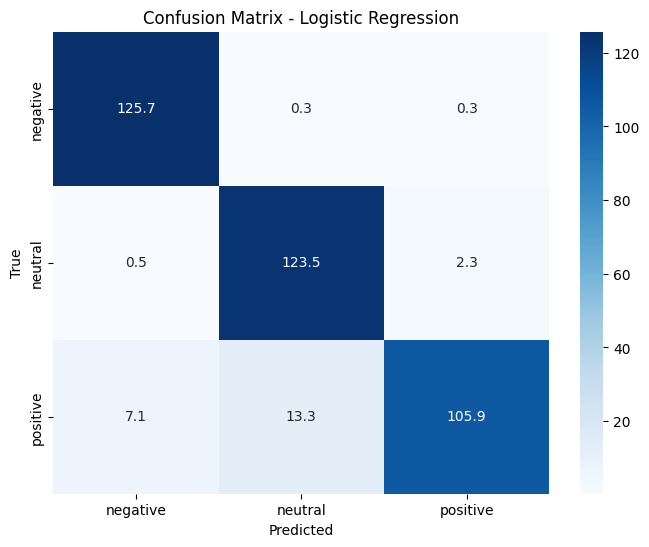

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 1. Google Colab'da GPU kullanımını kontrol etme
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Veri yükleme
def load_data(file_path):
    """Veriyi yükler ve döndürür"""
    data = pd.read_csv(file_path)
    return data

# Veri ön işleme: Vektörize etme ve label encoding
def preprocess_data(data):
    """Yorumları vektörize eder ve etiketleri sayısal hale getirir"""
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(data['Lemmatized_Comment'])

    encoder = LabelEncoder()
    y = encoder.fit_transform(data['Label'])

    return X, y, vectorizer, encoder

# Eğitim ve test verisine ayırma
def split_data(X, y):
    """Veriyi eğitim ve test olarak böler"""
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# SMOTE ile veri dengeleme
def apply_smote(X_train, y_train):
    """SMOTE ile veri setini dengele"""
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

# K-Fold Cross Validation fonksiyonu
def train_evaluate_models(X_train_resampled, y_train_resampled):
    """Modelleri eğitim ve test verisi ile eğitir ve değerlendirir"""
    svm_model = make_pipeline(StandardScaler(with_mean=False), SVC(kernel='linear', C=1, gamma='scale'))
    log_reg_model = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000, C=1, solver='liblinear'))

    svm_accuracies, log_reg_accuracies = [], []
    svm_f1_scores, log_reg_f1_scores = [], []
    svm_conf_matrix, log_reg_conf_matrix = [], []
    svm_predictions_all, log_reg_predictions_all, y_test_all = [], [], []

    svm_class_reports, log_reg_class_reports = [], []

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # K-Fold çapraz doğrulama ile her iki modelin eğitim ve test edilmesi
    for train_index, test_index in kf.split(X_train_resampled, y_train_resampled):
        X_train_fold, X_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
        y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]

        # SVM modelini eğitelim
        svm_model.fit(X_train_fold, y_train_fold)
        svm_predictions = svm_model.predict(X_test_fold)

        # Lojistik Regresyon modelini eğitelim
        log_reg_model.fit(X_train_fold, y_train_fold)
        log_reg_predictions = log_reg_model.predict(X_test_fold)

        # Performans metriklerini hesaplayalım
        svm_accuracies.append(accuracy_score(y_test_fold, svm_predictions))
        log_reg_accuracies.append(accuracy_score(y_test_fold, log_reg_predictions))

        svm_f1_scores.append(f1_score(y_test_fold, svm_predictions, average='macro'))
        log_reg_f1_scores.append(f1_score(y_test_fold, log_reg_predictions, average='macro'))

        # Confusion matrix
        svm_conf_matrix.append(confusion_matrix(y_test_fold, svm_predictions))
        log_reg_conf_matrix.append(confusion_matrix(y_test_fold, log_reg_predictions))

        # Classification report
        svm_class_reports.append(classification_report(y_test_fold, svm_predictions, output_dict=True))
        log_reg_class_reports.append(classification_report(y_test_fold, log_reg_predictions, output_dict=True))

        # Tahminleri ve gerçek etiketleri saklayalım
        svm_predictions_all.extend(svm_predictions)
        log_reg_predictions_all.extend(log_reg_predictions)
        y_test_all.extend(y_test_fold)

    return svm_accuracies, log_reg_accuracies, svm_f1_scores, log_reg_f1_scores, svm_conf_matrix, log_reg_conf_matrix, svm_predictions_all, log_reg_predictions_all, y_test_all, svm_class_reports, log_reg_class_reports

# Performans metriklerini yazdırma
def print_performance_metrics(svm_accuracies, log_reg_accuracies, svm_f1_scores, log_reg_f1_scores, svm_predictions_all, log_reg_predictions_all, y_test_all, svm_class_reports, log_reg_class_reports):
    """Ortalama metrikleri ve classification report'ları yazdırır"""
    svm_avg_accuracy = sum(svm_accuracies)/len(svm_accuracies)
    log_reg_avg_accuracy = sum(log_reg_accuracies)/len(log_reg_accuracies)
    svm_avg_f1 = sum(svm_f1_scores)/len(svm_f1_scores)
    log_reg_avg_f1 = sum(log_reg_f1_scores)/len(log_reg_f1_scores)

    print(f"SVM Average Accuracy: {svm_avg_accuracy:.4f}")
    print(f"Logistic Regression Average Accuracy: {log_reg_avg_accuracy:.4f}")
    print(f"SVM Average F1-Score: {svm_avg_f1:.4f}")
    print(f"Logistic Regression Average F1-Score: {log_reg_avg_f1:.4f}")

    print("\nSVM Classification Report:\n", classification_report(y_test_all, svm_predictions_all))
    print("\nLogistic Regression Classification Report:\n", classification_report(y_test_all, log_reg_predictions_all))

# Confusion matrix görselleştirme
def plot_confusion_matrix(cm, model_name, encoder):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Ana fonksiyon
def main(file_path):
    data = load_data(file_path)
    X, y, vectorizer, encoder = preprocess_data(data)
    X_train, X_test, y_train, y_test = split_data(X, y)
    X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)
    svm_accuracies, log_reg_accuracies, svm_f1_scores, log_reg_f1_scores, svm_conf_matrix, log_reg_conf_matrix, svm_predictions_all, log_reg_predictions_all, y_test_all, svm_class_reports, log_reg_class_reports = train_evaluate_models(X_train_resampled, y_train_resampled)

    print_performance_metrics(svm_accuracies, log_reg_accuracies, svm_f1_scores, log_reg_f1_scores, svm_predictions_all, log_reg_predictions_all, y_test_all, svm_class_reports, log_reg_class_reports)

    svm_avg_conf_matrix = sum(svm_conf_matrix) / len(svm_conf_matrix)
    log_reg_avg_conf_matrix = sum(log_reg_conf_matrix) / len(log_reg_conf_matrix)

    plot_confusion_matrix(svm_avg_conf_matrix, "SVM", encoder)
    plot_confusion_matrix(log_reg_avg_conf_matrix, "Logistic Regression", encoder)

# Dosya yolunu burada belirtin
file_path = 'lemmatized_comments_with_labels.csv'
main(file_path)


In [ ]:
#zero-shot

In [19]:
import torch
from transformers import pipeline
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the dataset
file_path = 'lemmatized_comments_with_labels.csv'
df = pd.read_csv(file_path)

# Use the Lemmatized_Comment for prediction
comments = df['Lemmatized_Comment'].tolist()

# Check if CUDA (GPU) is available and set the device accordingly
device = 0 if torch.cuda.is_available() else -1  # -1 means using CPU, 0 means using GPU

# Load a zero-shot classifier model (using Hugging Face's pipeline)
classifier = pipeline("zero-shot-classification", model="nlptown/bert-base-multilingual-uncased-sentiment", device=device)  # Use GPU if available

# Define possible labels
labels = ['positive', 'neutral', 'negative']

# Run zero-shot classification on the comments
results = []
for comment in comments:
    result = classifier(comment, candidate_labels=labels)
    results.append(result['labels'][0])  # Get the label with the highest score

# Add the predictions to the dataframe
df['Predicted_Label'] = results

# Calculate performance metrics
accuracy = accuracy_score(df['Label'], df['Predicted_Label'])
precision, recall, f1, _ = precision_recall_fscore_support(df['Label'], df['Predicted_Label'], labels=['positive', 'neutral', 'negative'], average='weighted')

# Save the dataframe with the predictions to a new CSV file
output_file = 'lemmatized_comments_with_predictions.csv'
df.to_csv(output_file, index=False)

# Print performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Provide the output file path
output_file


Device set to use cuda:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Accuracy: 0.6234
Precision: 0.5158
Recall: 0.6234
F1-score: 0.4910


'lemmatized_comments_with_predictions.csv'

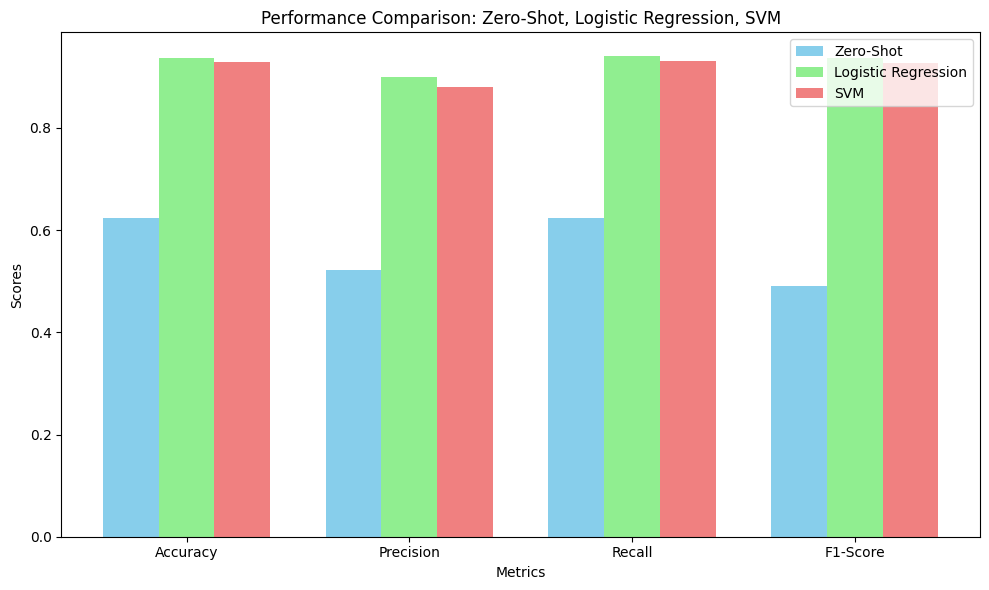

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Zero-shot model metrikleri: Zaten hesaplanmış
zero_shot_accuracy = 0.6242  # Zero-shot accuracy
zero_shot_precision = 0.5221
zero_shot_recall = 0.6242
zero_shot_f1 = 0.4914

# Logistic Regression ve SVM için ortalama metrikler: Verilen metrikler kullanılmıştır
svm_avg_accuracy = 0.9285  # SVM average accuracy
log_reg_avg_accuracy = 0.9372  # Logistic Regression average accuracy
svm_avg_f1 = 0.9268  # SVM average F1-score
log_reg_avg_f1 = 0.9360  # Logistic Regression average F1-score

# Performans metrikleri
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
zero_shot_scores = [zero_shot_accuracy, zero_shot_precision, zero_shot_recall, zero_shot_f1]
log_reg_scores = [log_reg_avg_accuracy, 0.90, 0.94, log_reg_avg_f1]  # Precision and Recall values for Logistic Regression (taken from the classification report)
svm_scores = [svm_avg_accuracy, 0.88, 0.93, svm_avg_f1]  # Precision and Recall values for SVM (taken from the classification report)

# Çubukların yerleri
x = np.arange(len(metrics))
width = 0.25

# Grafik oluşturma
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, zero_shot_scores, width, label='Zero-Shot', color='skyblue')
ax.bar(x, log_reg_scores, width, label='Logistic Regression', color='lightgreen')
ax.bar(x + width, svm_scores, width, label='SVM', color='lightcoral')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison: Zero-Shot, Logistic Regression, SVM')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


In [18]:
# Performans metriklerini yazdırma
print(f"SVM Average Accuracy: {svm_avg_accuracy:.4f}")
print(f"Logistic Regression Average Accuracy: {log_reg_avg_accuracy:.4f}")
print(f"Zero-Shot Accuracy: {zero_shot_accuracy:.4f}")
print("----------------------------------------")
print(f"SVM Average F1-Score: {svm_avg_f1:.4f}")
print(f"Logistic Regression Average F1-Score: {log_reg_avg_f1:.4f}")
print(f"Zero-Shot F1-Score: {zero_shot_f1:.4f}")

SVM Average Accuracy: 0.9285
Logistic Regression Average Accuracy: 0.9372
Zero-Shot Accuracy: 0.6242
----------------------------------------
SVM Average F1-Score: 0.9268
Logistic Regression Average F1-Score: 0.9360
Zero-Shot F1-Score: 0.4914
